#Поставновка задачи


Задача классификации. Мы хотим относить прицельный параметр к одному из классов, где классы - это какой-то отрезок. Получается для каждого столкновения мы имеем набор данных, который относится только к одному классу. Можно каждый раз перед началом данных каждого столкновения смотреть прицельный параметр, сразу относить его к назначенному классу и создать колонку, в которой и будет содержаться класс прицельного параметра. Именно эта колонка и будет нашим target'ом. Разбиения возьму следуюим образом: \\
(0; 7.0) - 1 класс, (7,0; 9,8) - 2 класс, (9,8; 12,0) - 3 класс, (12,0; 16,347) - 4 класс \\


Данные нужно готовить так, как будто они пришли на датчик. А датчик реагирует только на заряженные частицы, область, в которую прилетела частица и время пролёта частицы через сектор датчика. Регистрируется только первая пролетевшая частица через сектора датчика.

(0; 1.5) - 1 класс, (1.5; 16.347) - 2 класс (это будет моделироваться в дальнейшем) \\

In [157]:
import pandas as pd
import numpy as np

In [158]:
data_1_df = pd.read_csv('Data_1.csv', sep=';', index_col=False)

data_1_df.head()

,particle_charge,lepton_number,strangeness,baryon_number,type_of_particles,impulse_x,impulse_y,impulse_z,impulse_z_lab,param_5,mass
0,1,1062,7.226,-6.821,2.384,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,0.000,0.000,22.000,0.038747,0.098051,0.239720,2.91390,-0.239720,0.0
2,0,1,0.000,0.000,22.000,0.290970,-0.050649,-0.132510,1.09150,0.132510,0.0
3,0,1,0.000,0.000,22.000,-0.110860,0.841320,0.211970,6.28620,-0.211970,0.0
4,0,1,0.000,0.000,22.000,0.096298,0.001396,-0.098164,0.21856,0.098164,0.0


In [159]:
data_1_df.impulse_x[0]

nan

In [160]:
data_1_df.isna().sum()

particle_charge         0
lepton_number           0
strangeness             0
baryon_number           0
type_of_particles       0
impulse_x            2000
impulse_y            2000
impulse_z            2000
impulse_z_lab        2000
param_5              2000
mass                 2000
dtype: int64

In [161]:
data_1_df.shape

(1495919, 11)

In [162]:
# убрали пока не нужные колонки
data_1_df = data_1_df.drop(columns=['baryon_number', 'impulse_z_lab', 'param_5'])

# заменим все NaN, предполагая, что такого значения в массе нет, так как она должна быть положительна
data_1_df = data_1_df.fillna(-1)
data_1_df.head()

,particle_charge,lepton_number,strangeness,type_of_particles,impulse_x,impulse_y,impulse_z,mass
0,1,1062,7.226,2.384,-1.000000,-1.000000,-1.000000,-1.0
1,0,1,0.000,22.000,0.038747,0.098051,0.239720,0.0
2,0,1,0.000,22.000,0.290970,-0.050649,-0.132510,0.0
3,0,1,0.000,22.000,-0.110860,0.841320,0.211970,0.0
4,0,1,0.000,22.000,0.096298,0.001396,-0.098164,0.0


In [163]:
# проверка сколько у нас событий (то есть мест, где раньше стояли NaN)
data_1_df.query('mass == -1').agg({'mass': 'count'})

mass    2000
dtype: int64

(0; 7.0) - 1 класс, (7,0; 9,8) - 2 класс, (9,8; 12,0) - 3 класс, (12,0; 16,347) - 4 класс \\
$[a_i, b_i)$ - отрезок $i$ - ого класса. Где левая граница включена, а правая - нет.
Мы знаем количество частиц в событии (столкновении), но мы какую-то часть отфильтровываем (по зарядям и импульсам). Поэтому мы вначале для всех частиц сделаем классификацию по прицельному параметру, а потом отфильтруем ненужные. \\
Можно вначале сделать фильтрацию данных, а потом классификацию, но для этого нужно придумывать другой, более сложный алгоритм

In [164]:
# подвинем немного правую границу 4 класса, чтобы не возникло проблем на границе
borders = {1: [0, 7], 2: [7, 9.8], 3: [9.8, 12], 4: [12, 16.4]}

# функция определения класса
def define_class_impact_param(dist):
    for i in range(1, 5):
        if borders[i][0] <= dist < borders[i][1]:
            return i


# создадим функцию, которая будет брать только одно событие - данные с одного столкновения ядер.
# эти данные и нужно будет преобразовать в вектор признаков. idx - номер события, данные которого мы выбираем
def split_data_event(df, idx):
    data = pd.DataFrame()
    for i in range(df.shape[1]):
        if df.mass[i] == -1 and df.particle_charge[i] == idx:
            cnt_particle = df.lepton_number[i] # количество частиц в столкновении
            data = df[i + 1: i + 1 + cnt_particle] # вырезаем нужную часть

            class_param = define_class_impact_param(df.strangeness[i]) # класс прицельного параметра
            data.insert(0, "class_param", class_param)
            return data

data = split_data_event(data_1_df, 1)
data.head() # теперь эти данные нужно превратить в вектор

,class_param,particle_charge,lepton_number,strangeness,type_of_particles,impulse_x,impulse_y,impulse_z,mass
1,2,0,1,0.0,22.0,0.038747,0.098051,0.239720,0.0
2,2,0,1,0.0,22.0,0.290970,-0.050649,-0.132510,0.0
3,2,0,1,0.0,22.0,-0.110860,0.841320,0.211970,0.0
4,2,0,1,0.0,22.0,0.096298,0.001396,-0.098164,0.0
5,2,0,1,0.0,22.0,0.041370,0.257660,-0.085403,0.0


# Фильтрация
1) только заряженные частицы particle_charge != 0 \\
2) посчитаем длину вектора импульса \\
3) На первом этапе можно не учитывать тип частицы. \\
4) Данные после столкновения \\
5) Попадает ли частица на детектор - первый этап - очистить данные по различным параметрам \\

In [165]:
# больше нам эти колонки не нужны, так как мы уже сделали классификацию по прицельному параметру
data = data.drop(columns=['lepton_number', 'strangeness', 'type_of_particles'])
data = data.query("particle_charge != 0")
data.head()

,class_param,particle_charge,impulse_x,impulse_y,impulse_z,mass
19,2,1,0.228800,-0.220680,-0.856760,0.13957
21,2,1,-0.055182,0.188130,-0.458750,0.13957
25,2,1,0.096027,0.055379,0.066079,0.13957
34,2,1,-0.057866,0.056417,-0.195960,0.13957
36,2,1,-0.418190,-0.067341,9.104700,0.93828


## Импульс
|$\vec{P}| = \sqrt{p_{x}^2 + p_{y}^2+  p_{z}^2}$

In [166]:
# посчитали суммарный импульс для каждой частицы
def total_impulse(df):
    total = np.power(df.impulse_x, 2) + np.power(df.impulse_y, 2) + np.power(df.impulse_z, 2)
    return np.sqrt(total)

data['modul_sum_impulse'] = total_impulse(data)
data.head()

,class_param,particle_charge,impulse_x,impulse_y,impulse_z,mass,modul_sum_impulse
19,2,1,0.228800,-0.220680,-0.856760,0.13957,0.913831
21,2,1,-0.055182,0.188130,-0.458750,0.13957,0.498888
25,2,1,0.096027,0.055379,0.066079,0.13957,0.129052
34,2,1,-0.057866,0.056417,-0.195960,0.13957,0.211971
36,2,1,-0.418190,-0.067341,9.104700,0.93828,9.114548


##Зарегестрировавший датчик
Далее введём параметры нашего эксперимента: \\
- Внешний радиус кольца детектора - R
- Радиус выреза для 1-ого, 2-ого и 3-его кольца будем считатать одинаковым - $r_{cut}$ \\
- Расстояние до 1-ого, 2-ого и 3-его кольца соответственно - $dist_1$, $dist_2$, $dist_3$. \\



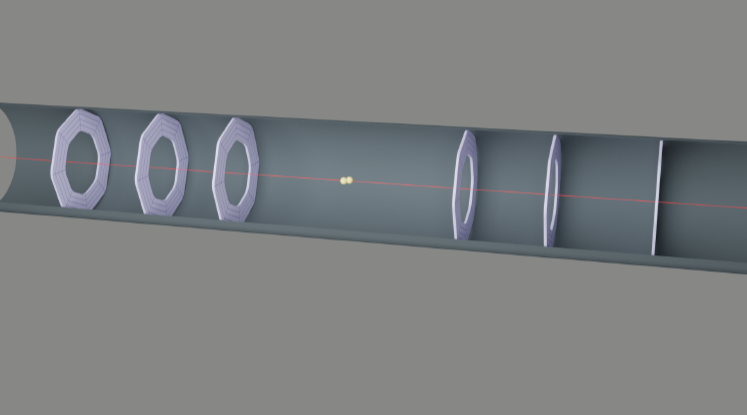

Введём сферические координаты: \\
$p_x = |\vec P| cos(ϕ) sin(θ)$ \\
$p_y = |\vec P| sin(ϕ) sin(θ)$ \\
$p_z = |\vec P| cos(ϴ)$ \\
где: $\phi \in [0; 2π], θ ∈ [0; π]$ \\

P.S ось z - направлена вдоль движения ядер

Сделаем фильтр, который будет проверять долетит ли частица хотя бы на какой нибудь из датчиков. \\
Условие отбора, что хотя бы какая-нибудь из частиц прилетит на датчик: \\
$α_0 <= θ <= β_0$, где: \\
$θ = arccos(\frac{p_z}{|\vec P|})$ \\
$α_0 = arctg(\frac{r_{cut}}{dist_3})$ \\
$β_0 = arctg(\frac{R}{dist_1})$

In [167]:
R = 2 # внешний радиус датчика !!! нужно выбрать то же значение, что и у Кирилла
r_cut = 0.3 # внутренный радиус датчика !!! нужно выбрать то же значение, что и у Кирилла
dist = [1, 3, 5] # расстояние до соответствующего датчика !!! нужно выбрать то же значение, что и у Кирилла

alpha_0 = np.arctan(r_cut / dist[2])
beta_0 = np.arctan(R / dist[0])

# долетает ли частица на какой-нибудь датчик.
def to_sensor(data):
    arccos = np.arccos(data.impulse_z / data.modul_sum_impulse)
    # положительное положение датчиков
    result_plus = arccos.between(alpha_0, beta_0, inclusive="neither")
    # отрицательное положение датчиков
    result_minus = arccos.between(np.pi - beta_0, np.pi - alpha_0, inclusive="neither")
    return result_plus | result_minus

data['to_any_sensor'] = to_sensor(data)
data = data.query("to_any_sensor == True") # убираем те частицы, которые не долетаю ни до одного датчика
data.shape

(403, 8)

In [168]:
# уберём колонки, которые уже не пригодятся
# здесь каждая частица долетит до какого-нибудь датчика. Поэтому to_any_sensor уже не нужна
data = data.drop(columns=["particle_charge", "to_any_sensor"])
data.head()

,class_param,impulse_x,impulse_y,impulse_z,mass,modul_sum_impulse
19,2,0.228800,-0.220680,-0.856760,0.13957,0.913831
21,2,-0.055182,0.188130,-0.458750,0.13957,0.498888
25,2,0.096027,0.055379,0.066079,0.13957,0.129052
34,2,-0.057866,0.056417,-0.195960,0.13957,0.211971
44,2,0.132900,-0.010070,2.130200,0.13957,2.134365


## На какой датчик прилетела частица

Теперь нужно реализовать: \\
1) Через какие датчики пролетает каждая частица \\
2) Разбиваем кольцо на сектора и пишем условия попадания в каждый сектор (см. тетрадь) \\
3) Оцениваем время пролёта частицы.

Для каждого датчика составим коллонку. Если частица пролетела через датчик в положительном положении => 1, если пролетела через симметричный датчик в отрицательном положении => -1, если не пролетела через датчик => 0

In [169]:
alpha_i = [np.arctan(r_cut / dist_i) for dist_i in dist] # минимальные углы для i датчика
beta_i = [np.arctan(R / dist_i) for dist_i in dist] # максимальный угол для i датчика

# создадим коллонку с акркосинусом угла тета
data["arccos_theta"] = np.arccos(data.impulse_z / data.modul_sum_impulse)

# этой функции передаём арккосинус угла и направление датчика
def between_corner(arccos_series, direct):
    if direct == 1:
        return arccos_series.between(alpha_i[j], beta_i[j])
    elif direct == -1:
        return arccos_series.between(np.pi - beta_i[j], np.pi - alpha_i[j])


# создаём коллонку для каждого датчика и делаем проверку по углам.
for j in range(3):
    name_column = "sensor_" + str(j + 1)
    data[name_column] = 0

    data.loc[between_corner(data.arccos_theta, 1), name_column] = 1
    data.loc[between_corner(data.arccos_theta, -1), name_column] = -1

data.head()

,class_param,impulse_x,impulse_y,impulse_z,mass,modul_sum_impulse,arccos_theta,sensor_1,sensor_2,sensor_3
19,2,0.228800,-0.220680,-0.856760,0.13957,0.913831,2.786309,-1,-1,-1
21,2,-0.055182,0.188130,-0.458750,0.13957,0.498888,2.737716,-1,-1,0
25,2,0.096027,0.055379,0.066079,0.13957,0.129052,1.033246,1,0,0
34,2,-0.057866,0.056417,-0.195960,0.13957,0.211971,2.750430,-1,-1,0
44,2,0.132900,-0.010070,2.130200,0.13957,2.134365,0.062486,0,0,1


In [170]:
data.shape

(403, 10)

##Разбиение на сектора

Введём 3 дополнительный радиуса - радиусы выреза на датчике. \\
Обязательное условие: $r_{cut} < r_1 < r_2 < r_3 < R$. В таком случае получится 4 кольца разбиения на датчике. \\
Также нужно ввести количество угол, который будет разделять сектора - $\frac{\pi}{4}$. \\
В таком случае получится 32 области разбиения датчика. Нумерацию областей предлагаю взять "улиткой" (см. фото ниже) \\
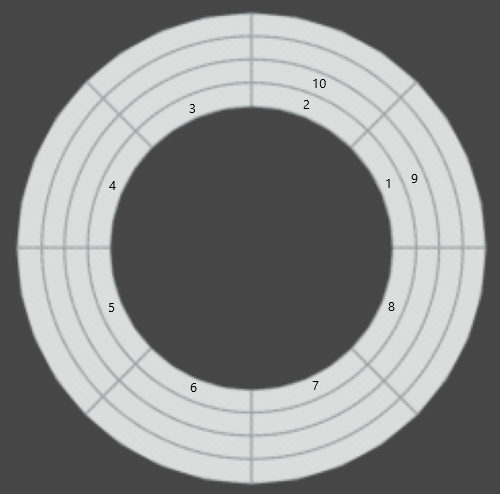

In [171]:
all_r = [r_cut, 0.7, 1.2, 1.6, R] # разбиние на кольца датчика
dist = [1, 3, 5] # расстояние до соответствующего датчика

"""
Определем номер кольца попадания частицы для каждого датчика
Внешний цикл создаёт коллонку для каждой пары датчика, в которой лежат нули.
Внутренний цикл проверяет в какое кольцо на датчике прилетает частица [0, 1, 2, 3] - 4 кольца
Функция between_corner работает с отбором по углам
Работает так, как и задумывалось, потому что если частица попала на датчик, то есть номер кольца
попадания, в случае, если частица не попала на датчик, то как и ожидалось, там 0
"""

def between_corner(arccos_series, direct): # нужно подумать над углами в between
    if direct == 1:
        return arccos_series.between(alpha_ring[j], alpha_ring[j + 1])
    elif direct == -1:
        return arccos_series.between(np.pi - alpha_ring[j + 1], np.pi - alpha_ring[j])


for i in range(3):
    name_column = "number_of_ring_" + str(i + 1)
    data[name_column] = 0

    for j in range(4):
        alpha_ring = [np.arctan(r / dist[i]) for r in all_r]

        # сделаем нумерацию подколец с 0, чтобы было удобнее определять сектор на датчике
        data.loc[between_corner(data.arccos_theta, 1), name_column] = j
        data.loc[between_corner(data.arccos_theta, -1), name_column] = j

data.head()

,class_param,impulse_x,impulse_y,impulse_z,mass,modul_sum_impulse,arccos_theta,sensor_1,sensor_2,sensor_3,number_of_ring_1,number_of_ring_2,number_of_ring_3
19,2,0.228800,-0.220680,-0.856760,0.13957,0.913831,2.786309,-1,-1,-1,0,1,3
21,2,-0.055182,0.188130,-0.458750,0.13957,0.498888,2.737716,-1,-1,0,0,2,0
25,2,0.096027,0.055379,0.066079,0.13957,0.129052,1.033246,1,0,0,3,0,0
34,2,-0.057866,0.056417,-0.195960,0.13957,0.211971,2.750430,-1,-1,0,0,2,0
44,2,0.132900,-0.010070,2.130200,0.13957,2.134365,0.062486,0,0,1,0,0,0


In [172]:
# цикл подобен коду выше, только теперь это делается для части окружности
def between_angle(left_border, rigth_border):
    result = data.arctg_phi.between(left_border, rigth_border)
    return result


def condition(column, sign_impulse_x, left_angle, rigth_angle):
    if sign_impulse_x == 1:
        return (data[column] != 0) & (data.impulse_x > 0) & (between_angle(left_angle, rigth_angle))
    elif sign_impulse_x == -1:
        return (data[column] != 0) & (data.impulse_x < 0) & (between_angle(left_angle, rigth_angle))


data["arctg_phi"] = np.arctan(data.impulse_y / data.impulse_x)

for i in range(3):
    name_column = "number_of_piece_" + str(i + 1)
    column_sensor = "sensor_" + str(i + 1)
    data[name_column] = 0

    data.loc[condition(column_sensor, 1, 0, np.pi / 4), name_column] = 1
    data.loc[condition(column_sensor, 1, np.pi / 4, np.pi / 2), name_column] = 2
    data.loc[condition(column_sensor, 1, -np.pi / 2, -np.pi / 4), name_column] = 7
    data.loc[condition(column_sensor, 1, -np.pi / 4, 0), name_column] = 8

    data.loc[condition(column_sensor, -1, -np.pi / 2, -np.pi / 4), name_column] = 3
    data.loc[condition(column_sensor, -1, -np.pi / 4, 0), name_column] = 4
    data.loc[condition(column_sensor, -1, 0, np.pi / 4),  name_column] = 5
    data.loc[condition(column_sensor, -1, np.pi / 4, np.pi / 2), name_column] = 6


data.head()

,class_param,impulse_x,impulse_y,impulse_z,mass,modul_sum_impulse,arccos_theta,sensor_1,sensor_2,sensor_3,number_of_ring_1,number_of_ring_2,number_of_ring_3,arctg_phi,number_of_piece_1,number_of_piece_2,number_of_piece_3
19,2,0.228800,-0.220680,-0.856760,0.13957,0.913831,2.786309,-1,-1,-1,0,1,3,-0.767335,8,8,8
21,2,-0.055182,0.188130,-0.458750,0.13957,0.498888,2.737716,-1,-1,0,0,2,0,-1.285481,3,3,0
25,2,0.096027,0.055379,0.066079,0.13957,0.129052,1.033246,1,0,0,3,0,0,0.523113,1,0,0
34,2,-0.057866,0.056417,-0.195960,0.13957,0.211971,2.750430,-1,-1,0,0,2,0,-0.772720,4,4,0
44,2,0.132900,-0.010070,2.130200,0.13957,2.134365,0.062486,0,0,1,0,0,0,-0.075627,0,0,8


In [173]:
# алгоритм определения сектора по кольцу попадания и куску по фи.
# Правильно ли реализован номер сектора? Нужно проверить есть ли номера >20.
# Действительно была ошибка, вроде бы исправлена

data["sector_1"] = (data.number_of_ring_1) * 8 + data.number_of_piece_1
data["sector_2"] = (data.number_of_ring_2) * 8 + data.number_of_piece_2
data["sector_3"] = (data.number_of_ring_3) * 8 + data.number_of_piece_3


# уберём все вспомогательные колонки
data = data.drop(columns=['number_of_ring_1', 'number_of_ring_2','number_of_ring_2',
                                    'number_of_piece_1', 'number_of_piece_2', 'number_of_piece_3',
                                    'arctg_phi', 'arccos_theta'])

# перестави колонки в приятном порядке
data = data[['class_param', 'impulse_x', 'impulse_y', 'impulse_z',
                       'modul_sum_impulse', 'mass', 'sensor_1', 'sector_1',
                       'sensor_2', 'sector_2', 'sensor_3', 'sector_3']]

data.head()

,class_param,impulse_x,impulse_y,impulse_z,modul_sum_impulse,mass,sensor_1,sector_1,sensor_2,sector_2,sensor_3,sector_3
19,2,0.228800,-0.220680,-0.856760,0.913831,0.13957,-1,8,-1,16,-1,32
21,2,-0.055182,0.188130,-0.458750,0.498888,0.13957,-1,3,-1,19,0,0
25,2,0.096027,0.055379,0.066079,0.129052,0.13957,1,25,0,0,0,0
34,2,-0.057866,0.056417,-0.195960,0.211971,0.13957,-1,4,-1,20,0,0
44,2,0.132900,-0.010070,2.130200,2.134365,0.13957,0,0,0,0,1,8


In [174]:
data.shape

(403, 12)

Надо бы подумать о том, как написать тест на правильность всех преобразований и что данные действительно отражают то, что я хотел сделать.

##Оценка времени пролёта




$u_z = \frac{p_z}{\sqrt{m_0 ^ 2 + |\vec P| ^ 2}}$ \\
имеем такую систему координат, в которой скорость света c = 1. \\
$t = \frac{S_z}{u_z}$ - время пролёта частицы до датчика. Для каждого датчика считаем время пролёта.


In [175]:
data["velocity"] = data.impulse_z / np.sqrt(data.mass ** 2 + data.modul_sum_impulse ** 2)


"""
нужно обрабатывать случаи, когда частица не прилетает на датчик
умножим расстояние на индикатор прилёта частицы 1, -1 или 0.
в случае, если частица НЕ прилетела на датчик, то и время пролёта будет 0
возьмём модуль, так как для времени не имеет значение, в каком направлении летит частица
"""
data["time_1"] = abs((dist[0] *  data.sensor_1) / data.velocity)
data["time_2"] = abs((dist[1] * data.sensor_2) / data.velocity)
data["time_3"] = abs((dist[2] * data.sensor_3) / data.velocity)

data.head()

,class_param,impulse_x,impulse_y,impulse_z,modul_sum_impulse,mass,sensor_1,sector_1,sensor_2,sector_2,sensor_3,sector_3,velocity,time_1,time_2,time_3
19,2,0.228800,-0.220680,-0.856760,0.913831,0.13957,-1,8,-1,16,-1,32,-0.926800,1.078981,3.236943,5.394905
21,2,-0.055182,0.188130,-0.458750,0.498888,0.13957,-1,3,-1,19,0,0,-0.885543,1.129251,3.387752,0.000000
25,2,0.096027,0.055379,0.066079,0.129052,0.13957,1,25,0,0,0,0,0.347619,2.876709,0.000000,0.000000
34,2,-0.057866,0.056417,-0.195960,0.211971,0.13957,-1,4,-1,20,0,0,-0.772122,1.295132,3.885397,0.000000
44,2,0.132900,-0.010070,2.130200,2.134365,0.13957,0,0,0,0,1,8,0.995921,0.000000,0.000000,5.020477


# Итоговый файл


In [ ]:
data = data.drop(columns=["velocity", "impulse_x", "impulse_y", "impulse_z",
                                    "modul_sum_impulse", "mass"])
data = data[["sensor_1", "sector_1", "time_1",
            "sensor_2", "sector_2", "time_2",
            "sensor_3", "sector_3", "time_3", "class_param"]]
data.head()

,sensor_1,sector_1,time_1,sensor_2,sector_2,time_2,sensor_3,sector_3,time_3,class_param
19,-1,8,1.078981,-1,16,3.236943,-1,32,5.394905,2
21,-1,3,1.129251,-1,19,3.387752,0,0,0.000000,2
25,1,25,2.876709,0,0,0.000000,0,0,0.000000,2
34,-1,4,1.295132,-1,20,3.885397,0,0,0.000000,2
44,0,0,0.000000,0,0,0.000000,1,8,5.020477,2


In [ ]:
data.shape

(403, 10)

# Создание результирующего вектора

sns_sct_{i}\_{j}\_plus - сенсор i сектор j в положительном направлении \\
sns_sct_{i}_{j}_minus - сенсор i сектор j в отрицательном направлении

In [ ]:
dct_res = {'class': [0]}

# создание нужных колонок
for i in range(1, 4):
    for j in range(1, 33):
        dct_res[f'sns_sct_{i}_{j}_plus'] = [0]
        dct_res[f'sns_sct_{i}_{j}_minus'] = [0]

res = pd.DataFrame(dct_res) # нулевой вектор длины 32 сенсора * 6 датчиков + 1 target = 193.

In [ ]:
# заполнение вектора res, который явлвяется отражением одного события (столкновения)
def position_in_res_vec(df):
    res['class'] = df.class_param.values[0]
    for i in range(1, 4):
        for j in range(1, 33):
            # создадим условие для нахождения минимального времени пролёта
            condition_plus = (data[f'sensor_{i}'] == 1) & (data[f'sector_{i}'] == j)
            condition_minus = (data[f'sensor_{i}'] == -1) & (data[f'sector_{i}'] == j)

            # сортируем по времени и берём самое меньшее время
            min_data_plus = data[condition_plus].sort_values(f'time_{i}')
            min_data_minus = data[condition_minus].sort_values(f'time_{i}')

            # возможны случаи, когда ни одна частица не пролетела через датчик
            if min_data_plus.shape[0] != 0:
                res[f'sns_sct_{i}_{j}_plus'] = min_data_plus[f'time_{i}'].values[0]

            if min_data_minus.shape[0] != 0:
                res[f'sns_sct_{i}_{j}_minus'] = min_data_minus[f'time_{i}'].values[0]


position_in_res_vec(data)
res

,class,sns_sct_1_1_plus,sns_sct_1_1_minus,sns_sct_1_2_plus,sns_sct_1_2_minus,sns_sct_1_3_plus,sns_sct_1_3_minus,sns_sct_1_4_plus,sns_sct_1_4_minus,sns_sct_1_5_plus,...,sns_sct_3_28_plus,sns_sct_3_28_minus,sns_sct_3_29_plus,sns_sct_3_29_minus,sns_sct_3_30_plus,sns_sct_3_30_minus,sns_sct_3_31_plus,sns_sct_3_31_minus,sns_sct_3_32_plus,sns_sct_3_32_minus
0,2,1.070476,1.134191,1.061568,1.063757,1.056732,1.071109,1.063262,1.074886,1.24914,...,5.316312,5.374428,6.245698,5.319103,0,5.537707,5.391234,5.321477,5.390097,5.339626
